# Download dataset

```python
import re
import requests
from requests.adapters import HTTPAdapter, Retry

# Regex to extract the next link from the Link header
re_next_link = re.compile(r'<(.+)>; rel="next"')

# Set up a session with retry logic
retries = Retry(total=5, backoff_factor=0.25, status_forcelist=[500, 502, 503, 504])
session = requests.Session()
session.mount("https://", HTTPAdapter(max_retries=retries))

# Function to get the next link from the response headers
def get_next_link(headers):
    if "Link" in headers:
        match = re_next_link.match(headers["Link"])
        if match:
            return match.group(1)

# Generator function to fetch batches of data
def get_batch(batch_url):
    while batch_url:
        response = session.get(batch_url)
        response.raise_for_status()  # Raise an error for failed requests
        yield response  # Yield the response for processing
        batch_url = get_next_link(response.headers)  # Get the next link

# Main function to download data
def download_uniref50_clusters(output_file, base_url, total_records=10000):
    progress = 0
    with open(output_file, "w") as f:
        for response in get_batch(base_url):
            # Write the response content to the file
            f.write(response.text)
            
            # Count records based on number of sequences
            progress += response.text.count(">")  # Count FASTA headers
            print(f"Downloaded {progress} / {total_records} clusters")

            # Stop when we reach the desired total
            if progress >= total_records:
                break
    print(f"Download complete! {progress} clusters saved to {output_file}")

# Define base URL for UniProt REST API
base_url = "https://rest.uniprot.org/uniref/search?query=identity:0.5&format=fasta&size=500"

# Download UniRef50 clusters
download_uniref50_clusters("uniref50_10000_clusters.fasta", base_url, total_records=100000)
```

import re
import requests
from requests.adapters import HTTPAdapter, Retry

# Regex to extract the next link from the Link header
re_next_link = re.compile(r'<(.+)>; rel="next"')

# Set up a session with retry logic
retries = Retry(total=5, backoff_factor=0.25, status_forcelist=[500, 502, 503, 504])
session = requests.Session()
session.mount("https://", HTTPAdapter(max_retries=retries))

# Function to get the next link from the response headers
def get_next_link(headers):
    if "Link" in headers:
        match = re_next_link.match(headers["Link"])
        if match:
            return match.group(1)

# Generator function to fetch batches of data
def get_batch(batch_url):
    while batch_url:
        response = session.get(batch_url)
        response.raise_for_status()  # Raise an error for failed requests
        yield response  # Yield the response for processing
        batch_url = get_next_link(response.headers)  # Get the next link

# Main function to download data
def download_uniref50_clusters(output_file, base_url, total_records=10000):
    progress = 0
    with open(output_file, "w") as f:
        for response in get_batch(base_url):
            # Write the response content to the file
            f.write(response.text)
            
            # Count records based on number of sequences
            progress += response.text.count(">")  # Count FASTA headers
            print(f"Downloaded {progress} / {total_records} clusters")

            # Stop when we reach the desired total
            if progress >= total_records:
                break
    print(f"Download complete! {progress} clusters saved to {output_file}")

# Define base URL for UniProt REST API
base_url = "https://rest.uniprot.org/uniref/search?query=identity:0.5+AND+length:[2000+TO+3000]&format=fasta&size=500"

# Download UniRef50 clusters
download_uniref50_clusters("uniref50_1000_clusters_2k-3k.fasta", base_url, total_records=1000)

# Define base URL for UniProt REST API
base_url = "https://rest.uniprot.org/uniref/search?query=identity:0.5+AND+length:[3000+TO+4000]&format=fasta&size=500"

# Download UniRef50 clusters
download_uniref50_clusters("uniref50_1000_clusters_3k-4k.fasta", base_url, total_records=1000)

# Load and Prepare Data

In [1]:
def set_seed(seed=42):
    import torch
    import random
    import numpy as np

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42) 

In [2]:
from Bio import SeqIO
import random
import torch
from sklearn.model_selection import train_test_split

# Load sequences from a FASTA file
def read_fasta(file):
    sequences = []
    for record in SeqIO.parse(file, "fasta"):
        sequences.append(str(record.seq))
    return sequences

# Apply masking to sequences for MLM
def mask_sequence(sequence, vocab, mask_token="[MASK]"):
    tokens = list(sequence)  # Convert sequence to tokens
    input_tokens = tokens[:]
    labels = [-100] * len(tokens)  # Default to -100 for non-masked positions

    # Mask 15% of tokens
    num_masks = max(1, int(len(tokens) * 0.15))
    mask_indices = random.sample(range(len(tokens)), num_masks)
    for idx in mask_indices:
        if random.random() < 0.8:  # 80% replace with [MASK]
            input_tokens[idx] = mask_token
        elif random.random() < 0.5:  # 10% replace with random amino acid
            input_tokens[idx] = random.choice(list(vocab))
        labels[idx] = vocab[tokens[idx]]  # Store the original token as the label

    return input_tokens, labels

# Create a dataset with tokenized and masked sequences
def prepare_data(sequences, vocab):
    data = []
    for seq in sequences:
        input_tokens, labels = mask_sequence(seq, vocab)
        input_ids = [vocab[tok] for tok in input_tokens]
        data.append((input_ids, labels))
    return data

# Define amino acid vocabulary
amino_acids = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"  # Standard amino acids
vocab = {aa: i for i, aa in enumerate(amino_acids)}
vocab["[MASK]"] = len(vocab)  # Add special [MASK] token
vocab["[PAD]"] = len(vocab)




# Define Transformer and Orchid Models

## Transformer Model

In [3]:
from transformers import BertConfig, BertForMaskedLM

# Define a transformer model (BERT)


## Orchid (Convolutional) Model

In [4]:
import torch
import torch.nn as nn
from torch.fft import rfft, irfft
from einops import rearrange
from transformers.modeling_outputs import MaskedLMOutput

class DiscreteTransform(nn.Module):
    def __init__(self, mode="fft", dim=-1):
        super().__init__()
        self.mode = mode
        self.dim = dim

    def forward(self, x):
        if self.mode == "fft":
            #print(f"fft {x.shape}")
            return rfft(x, dim=self.dim)

    def inverse(self, x):
        if self.mode == "fft":
            return irfft(x, dim=self.dim)

class BertEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids, token_type_ids=None):
        input_shape = input_ids.size()
        seq_length = input_shape[1]

        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand(input_shape)

        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=input_ids.device)

        word_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = word_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings  
'''    
class StaticConv(nn.Module):
    def __init__(self, d_model, d_filter, seq_len, vocab_size=vocab_size):
        super().__init__()
        # Create embeddings during initialization
        self.embeddings = BertEmbeddings(
            BertConfig(
                vocab_size=vocab_size,
                hidden_size=d_model,
                max_position_embeddings=seq_len,
                type_vocab_size=1,  # For simplicity, assuming one token type
                layer_norm_eps=1e-12,
                hidden_dropout_prob=0.1,
            )
        )

        # Generate static positional encodings during initialization
        with torch.no_grad():
            dummy_input_ids = torch.zeros(seq_len, dtype=torch.long).unsqueeze(0)  # [1, seq_len]
            self.static_filters = self.embeddings(dummy_input_ids).squeeze(0)  # [seq_len, d_model]

        # Feedforward network for CKConv-style processing
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_filter),
            nn.ReLU(),
            nn.Linear(d_filter, d_model),  # Ensure output size matches d_model
        )

    def forward(self, batch_size):
        # Expand static filters to match batch size
        expanded_filters = self.static_filters.unsqueeze(0).expand(batch_size, -1, -1)  # [batch_size, seq_len, d_model]

        # Apply feedforward network to static filters
        return self.ffn(expanded_filters)

class StaticConv(nn.Module):
    def __init__(self, d_model, d_filter, seq_len):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_filter),
            nn.ReLU(),
            nn.Linear(d_filter, d_model)  # Ensure output size matches d_model
        )
        self.positional_encoding = nn.Parameter(
            torch.randn(seq_len, d_model), requires_grad=True
        )  # Learnable positional encoding

    def forward(self, batch_size):
        # Expand positional encodings to include the batch dimension
        batch_positional_encoding = self.positional_encoding.unsqueeze(0).expand(batch_size, -1, -1)
        # Apply feedforward network to each position
        return self.ffn(batch_positional_encoding)
'''

class StaticConv(nn.Module):
    def __init__(self, d_model, seq_len):
        super().__init__()
        self.positional_encoding = nn.Parameter(
            torch.zeros(seq_len, d_model), requires_grad=False  # Non-learnable zeros
        )

    def forward(self, batch_size):
        # Expand positional encodings to include the batch dimension
        batch_positional_encoding = self.positional_encoding.unsqueeze(0).expand(batch_size, -1, -1)
        return batch_positional_encoding


class Abs(nn.Module):
    def forward(self, x):
        return torch.abs(x)
    
class OrchidOperator(nn.Module):
    def __init__(self, d, seq_len, d_filter=64, l_conv1d=3, transform_mode="fft"):
        super().__init__()
        self.d_model = d
        self.seq_len = seq_len

        self.in_linear = nn.Linear(d, 3 * d)
        self.out_linear = nn.Linear(d, d)

        width = d * 3
        self.short_filter = nn.Conv1d(width , width , kernel_size = l_conv1d , groups =width , padding = l_conv1d // 2)
        '''
        self.short_filter = nn.Conv1d(
            d, d, kernel_size=l_conv1d, groups=d, padding=l_conv1d // 2
        )

        
        self.static_conv = nn.Sequential(
            nn.Linear(d, d_filter), nn.ReLU(), nn.Linear(d_filter, d_filter)
        )
        '''
        
       
        self.static_conv = StaticConv(d, seq_len)
        #self.static_conv = StaticConv(d, d_filter, seq_len)

        self.conditioning_nn = nn.Sequential(
            nn.Conv1d(d, d, kernel_size = l_conv1d, padding=l_conv1d // 2, groups=d),
            DiscreteTransform(mode=transform_mode, dim=-1),
            Abs(),
            nn.Conv1d(d, d, kernel_size = l_conv1d, padding=l_conv1d // 2, groups=d),
        )

        self.transform = DiscreteTransform(mode=transform_mode, dim=-1)

    def forward(self, x):
        batch, seq_len, dim = x.size()
        orig_x = x

        x = self.in_linear(x)
        x = nn.functional.gelu(x)
        #_, _, v = torch.split(x, dim, dim=-1)
        _, _, v = x.split(self.d_model, dim=-1)
        #print(v.shape)

        h_adapt_f = self.conditioning_nn(rearrange(v, "b l d -> b d l"))
        
        h_static = self.static_conv(batch).transpose(1, 2)

        x = rearrange(x, "b l d -> b d l")
        x = self.short_filter(x)[..., : self.seq_len]
        s1, s2, v = x.split(self.d_model, dim=1)

        y = v * s1
        y = self.adaptive_conv(y, h_static, h_adapt_f)
        y = y * s2
        y = rearrange(y, "b d l -> b l d")
        y = self.out_linear(y)
        y = nn.functional.gelu(y)

        return self.out_linear(y)

    def adaptive_conv(self, x, h_static, h_adapt_f):
        h_static_f = self.transform(h_static)
        x_f = self.transform(x)
        
        #print(f"self seq {self.seq_len}, h_static_f {h_static_f.shape}, h_adapt_f {h_adapt_f.shape},  x_f { x_f.shape},  h_static {h_static.shape}, x {x.shape}")
        
        y = self.transform.inverse(x_f * (h_static_f + h_adapt_f))
        return y[..., : self.seq_len]

class OrchidBertLayer(nn.Module):
    def __init__(self, config, seq_len, l_conv1d):
        super().__init__()
        self.seq_len = seq_len
        self.orchid = OrchidOperator(
            d=config.hidden_size,
            seq_len=seq_len,
            d_filter=64,  # Adjust as needed
            l_conv1d=l_conv1d,   # Adjust as needed
            transform_mode="fft"
        )
        self.intermediate = nn.Linear(config.hidden_size, config.intermediate_size)
        self.output = nn.Linear(config.intermediate_size, config.hidden_size)
        self.norm1 = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.norm2 = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout1 = nn.Dropout(config.hidden_dropout_prob)
        self.dropout2 = nn.Dropout(config.hidden_dropout_prob)

        '''
    def forward(self, hidden_states, position_embeddings):
        # Pass hidden_states and positional embeddings to Orchid layer
        orchid_output = self.orchid(hidden_states + position_embeddings)
        hidden_states = hidden_states + self.dropout1(orchid_output)
        hidden_states = self.norm1(hidden_states)

        # Feedforward block
        intermediate_output = self.intermediate(hidden_states)
        intermediate_output = nn.functional.gelu(intermediate_output)
        layer_output = self.output(intermediate_output)
        hidden_states = hidden_states + self.dropout2(layer_output)
        hidden_states = self.norm2(hidden_states)

        return hidden_states
        '''
    
    def forward(self, hidden_states):
        # Pass hidden_states and positional embeddings to Orchid layer
        orchid_output = self.orchid(hidden_states)
        hidden_states = hidden_states + self.dropout1(orchid_output)
        hidden_states = self.norm1(hidden_states)

        # Feedforward block
        intermediate_output = self.intermediate(hidden_states)
        intermediate_output = nn.functional.gelu(intermediate_output)
        layer_output = self.output(intermediate_output)
        hidden_states = hidden_states + self.dropout2(layer_output)
        hidden_states = self.norm2(hidden_states)

        return hidden_states

class OrchidBERT(nn.Module):
    def __init__(self, config, seq_len, l_conv1d):
        super().__init__()
        self.embeddings = BertEmbeddings(config)
        self.encoder_layers = nn.ModuleList(
            [OrchidBertLayer(config, seq_len, l_conv1d) for _ in range(config.num_hidden_layers)]
        )
        self.cls_head = nn.Linear(config.hidden_size, config.vocab_size)  # For Masked LM

    def forward(self, input_ids, attention_mask=None):
        # Compute embeddings
        embeddings = self.embeddings(input_ids)
        #position_embeddings = self.embeddings.position_embeddings.weight.unsqueeze(0)
        hidden_states = embeddings

        # Apply attention mask to embeddings if needed
        if attention_mask is not None:
            attention_mask = attention_mask.unsqueeze(-1)  # Match embedding dimensions
            hidden_states = hidden_states * attention_mask
        
        
        # Pass through Orchid-enhanced Transformer layers
        for layer in self.encoder_layers:
            #hidden_states = layer(hidden_states, position_embeddings)
            hidden_states = layer(hidden_states)

        logits = self.cls_head(hidden_states)
        probs = nn.functional.softmax(logits, dim=-1)
        
        return MaskedLMOutput(
            loss=None,
            logits=probs,
            hidden_states=None,  # Optionally return hidden states if needed
            attentions=None      # Optionally return attentions if needed
        )

# Test

In [6]:
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Custom PyTorch Dataset
class ProteinDataset(Dataset):
    def __init__(self, data, max_len, pad_token="[PAD]"):
        self.data = data
        self.max_len = max_len
        self.pad_token = pad_token

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_ids, labels = self.data[idx]

        # Pad input_ids and labels to max_len
        padding_length = self.max_len - len(input_ids)
        if padding_length > 0:
            input_ids = input_ids + [vocab[self.pad_token]] * padding_length
            labels = labels + [-100] * padding_length
            
        attention_mask = [1] * (self.max_len - padding_length) + [0] * padding_length

        return (
            torch.tensor(input_ids),
            torch.tensor(labels),
            torch.tensor(attention_mask)
        )    

# Training Loop
def train(model, train_loader, val_loader, save_path, epochs=20, patience=3):
    optimizer = AdamW(model.parameters(), lr=5e-4)
    criterion = nn.CrossEntropyLoss(ignore_index=-100)  # Ignore non-masked positions

    train_acc, val_acc = [], []
    best_val_loss = float("inf")
    best_val_acc = 0.0
    early_stop_counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss, correct, total = 0, 0, 0
        #for input_ids, labels, attention_mask in train_loader:
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
            # Process each batch
            input_ids = batch[0].long().to(device, non_blocking=True)
            labels = batch[1].long().to(device, non_blocking=True)
            attention_mask = batch[2].long().to(device, non_blocking=True)
            optimizer.zero_grad()
            logits = model(input_ids,attention_mask=attention_mask).logits
            loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
            #loss = criterion(logits.logits.view(-1, logits.logits.size(-1)), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Compute accuracy
            predictions = logits.argmax(dim=-1)
            #print(f"pred {predictions.shape}, label {labels.shape}")
            correct += (predictions == labels).sum().item()
            total += (labels != -100).sum().item()
            
            #print(predictions)
            #print(labels)
        train_acc.append(correct / total)

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            #for input_ids, labels, attention_mask in val_loader:
            for batch in tqdm(val_loader, desc=f"Val Epoch {epoch + 1}"):
                # Process each batch
                input_ids = batch[0].to(device, non_blocking=True)
                labels = batch[1].to(device, non_blocking=True)
                attention_mask = batch[2].to(device, non_blocking=True)
                logits = model(input_ids,attention_mask=attention_mask).logits
                loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
                val_loss += loss.item()
                predictions = logits.argmax(dim=-1)
                correct += (predictions == labels).sum().item()
                total += (labels != -100).sum().item()
                

        val_acc.append(correct / total)

        print(f"Epoch {epoch + 1}: Train Acc={train_acc[-1]:.4f}, Val Acc={val_acc[-1]:.4f}")
        
        # Save the best model (based on validation accuracy)
        if val_acc[-1] > best_val_acc or (val_acc[-1] == best_val_acc and val_loss < best_val_loss):
            print(f"Saving model with Val Acc={val_acc[-1]:.4f}, Val Loss={val_loss:.4f}")
            best_val_acc = val_acc[-1]
            #best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            
        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping...")
                break

    return train_acc, val_acc



In [7]:
# Test the Model
def test(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        #for input_ids, labels, attention_mask in test_loader:
        for batch in tqdm(test_loader, desc=f"Test"):
            # Process each batch
            input_ids = batch[0].to(device, non_blocking=True)
            labels = batch[1].to(device, non_blocking=True)
            attention_mask = batch[2].to(device, non_blocking=True)
            logits = model(input_ids,attention_mask=attention_mask).logits
            predictions = logits.argmax(dim=-1)
            correct += (predictions == labels).sum().item()
            total += (labels != -100).sum().item()
    return correct / total



In [8]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('model size: {:.3f}MB'.format(size_all_mb))
    return size_all_mb

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_2228\3301841325.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer_model.load_state_dict(torch.load

Transformer Test Accuracy at sequence length 1000: 0.1698
Orchid Test Accuracy at sequence length 1000: 0.1651


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


Transformer Test Accuracy at sequence length 2000: 0.1815
Orchid Test Accuracy at sequence length 2000: 0.1902
3000


Val Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.32s/it]


Epoch 1: Train Acc=0.1016, Val Acc=0.1402
Saving model with Val Acc=0.1402, Val Loss=14.4660


Val Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.26s/it]


Epoch 2: Train Acc=0.1584, Val Acc=0.1639
Saving model with Val Acc=0.1639, Val Loss=13.9369


Val Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.34s/it]


Epoch 3: Train Acc=0.1728, Val Acc=0.1673
Saving model with Val Acc=0.1673, Val Loss=13.7510


Val Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.26s/it]


Epoch 4: Train Acc=0.1822, Val Acc=0.1747
Saving model with Val Acc=0.1747, Val Loss=13.6390


Val Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.30s/it]


Epoch 5: Train Acc=0.1982, Val Acc=0.1776
Saving model with Val Acc=0.1776, Val Loss=13.6102


Val Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.27s/it]


Epoch 6: Train Acc=0.2051, Val Acc=0.1801
Saving model with Val Acc=0.1801, Val Loss=13.6046


Val Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.29s/it]


Epoch 7: Train Acc=0.2081, Val Acc=0.1822
Saving model with Val Acc=0.1822, Val Loss=13.6203


Val Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.30s/it]


Epoch 8: Train Acc=0.2114, Val Acc=0.1812


Val Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.29s/it]


Epoch 9: Train Acc=0.2145, Val Acc=0.1812
Early stopping...


Val Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


Epoch 1: Train Acc=0.0763, Val Acc=0.0866
Saving model with Val Acc=0.0866, Val Loss=16.4489


Val Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 2: Train Acc=0.0954, Val Acc=0.0975
Saving model with Val Acc=0.0975, Val Loss=16.4088


Val Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 3: Train Acc=0.1055, Val Acc=0.1153
Saving model with Val Acc=0.1153, Val Loss=16.3523


Val Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 4: Train Acc=0.1226, Val Acc=0.1292
Saving model with Val Acc=0.1292, Val Loss=16.2871


Val Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 5: Train Acc=0.1294, Val Acc=0.1363
Saving model with Val Acc=0.1363, Val Loss=16.2584


Val Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 6: Train Acc=0.1412, Val Acc=0.1448
Saving model with Val Acc=0.1448, Val Loss=16.2097


Val Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 7: Train Acc=0.1529, Val Acc=0.1574
Saving model with Val Acc=0.1574, Val Loss=16.1545


Val Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 8: Train Acc=0.1639, Val Acc=0.1651
Saving model with Val Acc=0.1651, Val Loss=16.1194


Val Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 9: Train Acc=0.1758, Val Acc=0.1740
Saving model with Val Acc=0.1740, Val Loss=16.0753


Val Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 10: Train Acc=0.1785, Val Acc=0.1725


Val Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 11: Train Acc=0.1851, Val Acc=0.1815
Saving model with Val Acc=0.1815, Val Loss=16.0411


Val Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.03s/it]


Epoch 12: Train Acc=0.1929, Val Acc=0.1860
Saving model with Val Acc=0.1860, Val Loss=16.0167


Val Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 13: Train Acc=0.1974, Val Acc=0.1863
Saving model with Val Acc=0.1863, Val Loss=16.0136


Val Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 14: Train Acc=0.1998, Val Acc=0.1853


Val Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 15: Train Acc=0.2021, Val Acc=0.1860


Val Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


Epoch 16: Train Acc=0.2050, Val Acc=0.1859
Early stopping...


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


Transformer Test Accuracy at sequence length 3000: 0.1794
Orchid Test Accuracy at sequence length 3000: 0.1862
4000


Val Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.24s/it]


Epoch 1: Train Acc=0.0974, Val Acc=0.1263
Saving model with Val Acc=0.1263, Val Loss=14.4726


Val Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.23s/it]


Epoch 2: Train Acc=0.1538, Val Acc=0.1628
Saving model with Val Acc=0.1628, Val Loss=13.9264


Val Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.25s/it]


Epoch 3: Train Acc=0.1710, Val Acc=0.1662
Saving model with Val Acc=0.1662, Val Loss=13.6555


Val Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.28s/it]


Epoch 4: Train Acc=0.1839, Val Acc=0.1778
Saving model with Val Acc=0.1778, Val Loss=13.5477


Val Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.24s/it]


Epoch 5: Train Acc=0.2020, Val Acc=0.1878
Saving model with Val Acc=0.1878, Val Loss=13.4511


Val Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.23s/it]


Epoch 6: Train Acc=0.2106, Val Acc=0.1895
Saving model with Val Acc=0.1895, Val Loss=13.4541


Val Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.23s/it]


Epoch 7: Train Acc=0.2152, Val Acc=0.1903
Saving model with Val Acc=0.1903, Val Loss=13.4329


Val Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.25s/it]


Epoch 8: Train Acc=0.2169, Val Acc=0.1884


Val Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.23s/it]


Epoch 9: Train Acc=0.2190, Val Acc=0.1867


Val Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.22s/it]


Epoch 10: Train Acc=0.2211, Val Acc=0.1891
Early stopping...


Val Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.63s/it]


Epoch 1: Train Acc=0.0864, Val Acc=0.0934
Saving model with Val Acc=0.0934, Val Loss=16.4439


Val Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 2: Train Acc=0.0980, Val Acc=0.1040
Saving model with Val Acc=0.1040, Val Loss=16.4189


Val Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 3: Train Acc=0.1068, Val Acc=0.1144
Saving model with Val Acc=0.1144, Val Loss=16.3666


Val Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 4: Train Acc=0.1213, Val Acc=0.1296
Saving model with Val Acc=0.1296, Val Loss=16.2953


Val Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 5: Train Acc=0.1324, Val Acc=0.1327
Saving model with Val Acc=0.1327, Val Loss=16.2638


Val Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 6: Train Acc=0.1376, Val Acc=0.1512
Saving model with Val Acc=0.1512, Val Loss=16.2053


Val Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 7: Train Acc=0.1529, Val Acc=0.1523
Saving model with Val Acc=0.1523, Val Loss=16.1723


Val Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 8: Train Acc=0.1561, Val Acc=0.1555
Saving model with Val Acc=0.1555, Val Loss=16.1585


Val Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 9: Train Acc=0.1677, Val Acc=0.1656
Saving model with Val Acc=0.1656, Val Loss=16.1080


Val Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.64s/it]


Epoch 10: Train Acc=0.1770, Val Acc=0.1749
Saving model with Val Acc=0.1749, Val Loss=16.0666


Val Epoch 11: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 11: Train Acc=0.1843, Val Acc=0.1750
Saving model with Val Acc=0.1750, Val Loss=16.0570


Val Epoch 12: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.61s/it]


Epoch 12: Train Acc=0.1888, Val Acc=0.1802
Saving model with Val Acc=0.1802, Val Loss=16.0390


Val Epoch 13: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 13: Train Acc=0.1940, Val Acc=0.1884
Saving model with Val Acc=0.1884, Val Loss=16.0012


Val Epoch 14: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 14: Train Acc=0.1992, Val Acc=0.1843


Val Epoch 15: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 15: Train Acc=0.2031, Val Acc=0.1922
Saving model with Val Acc=0.1922, Val Loss=15.9832


Val Epoch 16: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 16: Train Acc=0.2097, Val Acc=0.1948
Saving model with Val Acc=0.1948, Val Loss=15.9685


Val Epoch 17: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 17: Train Acc=0.2131, Val Acc=0.1954
Saving model with Val Acc=0.1954, Val Loss=15.9664


Val Epoch 18: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 18: Train Acc=0.2145, Val Acc=0.1948


Val Epoch 19: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.61s/it]


Epoch 19: Train Acc=0.2166, Val Acc=0.1942


Val Epoch 20: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.61s/it]


Epoch 20: Train Acc=0.2192, Val Acc=0.1928
Early stopping...


Test: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.29s/it]


Transformer Test Accuracy at sequence length 4000: 0.1876
Orchid Test Accuracy at sequence length 4000: 0.1910


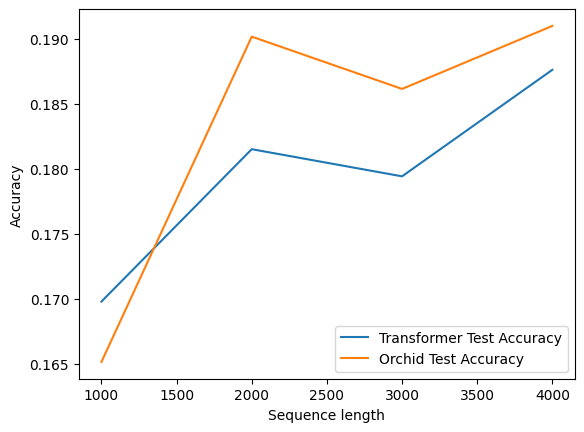

In [16]:

transformer_test_accuracy_list = []
orchid_test_accuracy_list = []
seq_list = []
sequences = []
fasta_files = ["uniref50_10000_clusters.fasta", "uniref50_1000_clusters_2k-3k.fasta", "uniref50_1000_clusters_3k-4k.fasta"]
for fasta_file in fasta_files:
    sequences += read_fasta(fasta_file)
sequences = list(set(sequences))
'''
# Read sequences and split into train/val/test
fasta_file = "uniref50_10000_clusters.fasta"
sequences = read_fasta(fasta_file)
#sequences = sequences[:len(sequences)]
'''

skip = [1000,2000]

max_data_count = 1000

for seq_len in range(1000,5000,1000):
#seq_len = 2048
    sequences_cut  = [s for s in sequences if (len(s)<=seq_len and len(s)>seq_len - 1000)]
    
    if len(sequences_cut) > max_data_count:  
        sequences_cut = sequences_cut[:max_data_count]
    
    train_seqs, temp_seqs = train_test_split(sequences_cut, test_size=0.3, random_state=42)
    val_seqs, test_seqs = train_test_split(temp_seqs, test_size=0.5, random_state=42)

    # Tokenize and mask sequences
    train_data = prepare_data(train_seqs, vocab)
    val_data = prepare_data(val_seqs, vocab)
    test_data = prepare_data(test_seqs, vocab)
    
    config = BertConfig(
        vocab_size=len(vocab),  # Number of tokens in the vocabulary
        hidden_size=128,
        num_hidden_layers=3,
        num_attention_heads=2,
        intermediate_size=256,
        hidden_dropout_prob=0.1,
        max_position_embeddings=seq_len
    )
    
    transformer_model = BertForMaskedLM(config)
    
    vocab_size = len(vocab)
    # Adjust based on your dataset
    orchid_model = OrchidBERT(config, seq_len, l_conv1d=11)
    
    # Prepare DataLoaders
    batch_size = 32
    train_loader = DataLoader(ProteinDataset(train_data, seq_len), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(ProteinDataset(val_data, seq_len), batch_size=batch_size)
    test_loader = DataLoader(ProteinDataset(test_data, seq_len), batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    transformer_model.to(device)
    orchid_model.to(device)

    transformer_path = f"transformer_model_{seq_len}"
    orchid_path = f"orchid_model_tmp_{seq_len}"
    
    if seq_len not in skip:
        print(seq_len)
        transformer_acc = train(transformer_model, train_loader, val_loader,transformer_path)
        orchid_acc = train(orchid_model, train_loader, val_loader,orchid_path)
    
    transformer_model = BertForMaskedLM(config)  # Replace with your model's class
    transformer_model.load_state_dict(torch.load(transformer_path))
    transformer_model.to(device)

    orchid_model = OrchidBERT(config, seq_len, l_conv1d=11)  # Replace with your model's class
    orchid_model.load_state_dict(torch.load(orchid_path))
    orchid_model.to(device)
    
    transformer_test_acc = test(transformer_model, test_loader)
    orchid_test_acc = test(orchid_model, test_loader)

    print(f"Transformer Test Accuracy at sequence length {seq_len}: {transformer_test_acc:.4f}")
    print(f"Orchid Test Accuracy at sequence length {seq_len}: {orchid_test_acc:.4f}")
    
    transformer_test_accuracy_list.append(transformer_test_acc)
    orchid_test_accuracy_list.append(orchid_test_acc)
    seq_list.append(seq_len)

# Plot Training and Validation Accuracy
plt.plot(seq_list, transformer_test_accuracy_list, label="Transformer Test Accuracy")
plt.plot(seq_list, orchid_test_accuracy_list, label="Orchid Test Accuracy")
plt.xlabel('Sequence length') 
plt.ylabel('Accuracy') 
plt.legend()
plt.show()